In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import networkx as nx
import trimesh
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pyvista as pv
import open3d as o3d
import trimesh
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Supplementary figure 4
1D system

In [ ]:

def simulate_1D_Turing_LC(parameter_space_len,turing_len,n_lc):
    intersection = 0
    encounter_list = []
    point_count = 0
    for i in range(n_lc):
        turing_initial = np.random.uniform(turing_len/2,parameter_space_len-(turing_len/2))
        turing_start = turing_initial-(turing_len/2)
        turing_end = turing_initial+(turing_len/2)
        LC_len = np.random.uniform(1e-9,parameter_space_len)
        if LC_len == parameter_space_len:
            intersection = intersection + 1
            encounter_list.append((turing_end-turing_start)/LC_len)
            continue
        LC_initial = np.random.uniform(LC_len/2,parameter_space_len-(LC_len/2))
        LC_start = LC_initial-(LC_len/2)
        LC_end = LC_initial+(LC_len/2)
        #print(LC_start,LC_end,turing_start,turing_end)
        if LC_start>turing_end or LC_end < turing_start:
            encounter = 0
        else:
            if LC_start <= turing_start and LC_end >= turing_end:
                encounter = (turing_end-turing_start)/LC_len
            else:
                if LC_start <= turing_start and LC_end < turing_end:
                    encounter = (LC_end-turing_start)/LC_len
                if LC_start > turing_start and LC_end >= turing_end:
                    encounter = (turing_end-LC_start)/LC_len
                if LC_start > turing_start and LC_end < turing_end:
                    encounter = 1
            intersection = intersection + 1
        encounter_list.append(encounter)
        point_loc = np.random.uniform(1e-9,parameter_space_len)
        if turing_start <= point_loc and turing_end >= point_loc:
            point_count = point_count + 1
    point_prob = point_count/n_lc
    intersection_prob = intersection/n_lc
        
        

    return(intersection_prob,np.mean(encounter_list),point_prob)

In [ ]:
intersection_list_1D = []
encounter_mean_list_1D = []
point_list_1D = []
for i in range(35,800,1):
    intersection_p, encounter_list, point_prob = simulate_1D_Turing_LC(i,turing_len,100000)
    intersection_list_1D.append(intersection_p)
    encounter_mean_list_1D.append(encounter_list)
    point_list_1D.append(point_prob)

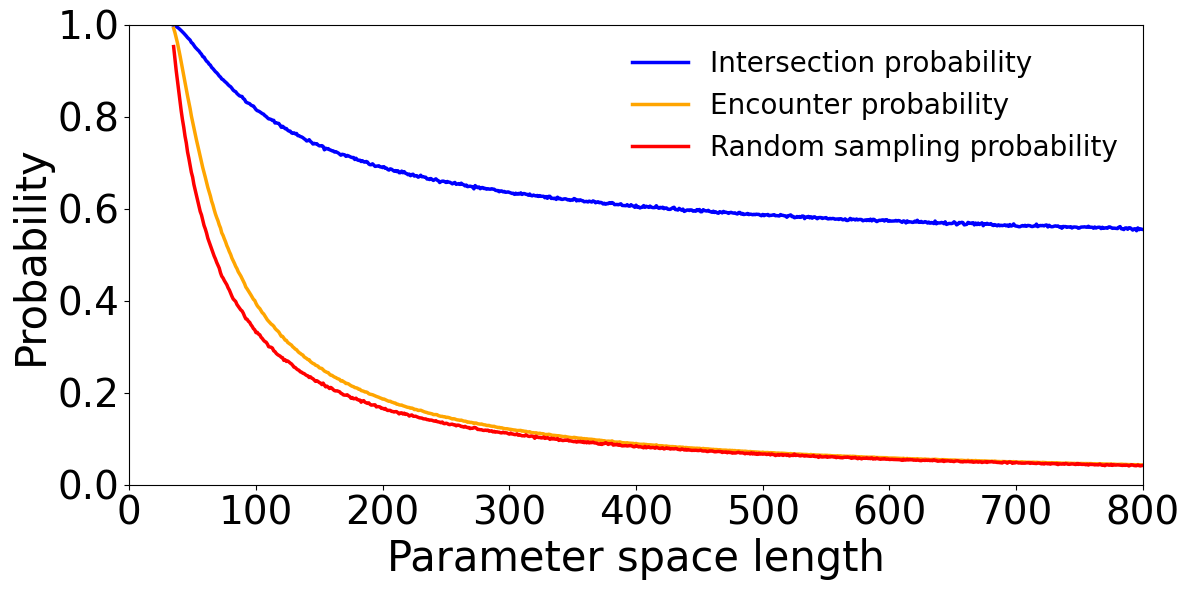

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(35,800,1),intersection_list_1D, color = "blue", label = "Intersection probability",linewidth=2.5)
plt.plot(np.arange(35,800,1),encounter_mean_list_1D, color = "orange",label = "Encounter probability",linewidth=2.5)
plt.plot(np.arange(35,800,1),point_list_1D, color = "red",label = "Random sampling probability",linewidth=2.5)
plt.xlim(0,800)
plt.ylim(0,1)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Parameter space length",fontsize = 30)
plt.ylabel("Probability",fontsize = 30)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.tight_layout()
plt.savefig("Images_for_paper/1D_LC_suppv2.png")
plt.show()

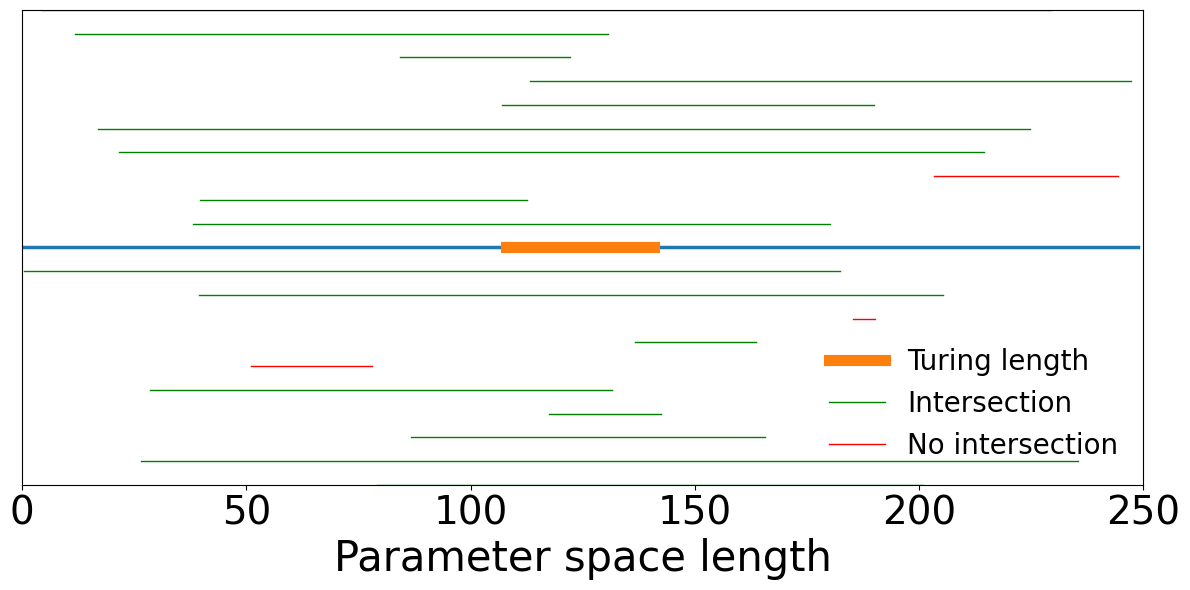

In [18]:
plt.figure(figsize=(12, 6))
main_line_x = np.arange(0,250,1)
main_line_y = np.arange(0,250,1)*0 + 2
plt.plot(main_line_x, main_line_y,linewidth = 2.5)
turing_line_x = np.arange(125-17,125+17,1)
turing_line_y = np.arange(125-17,125+17,1)*0+2

plt.plot(turing_line_x,turing_line_y, linewidth = 8, label = "Turing length")
param_space = 250
for i in range(21):
    LC_len = np.random.uniform(1e-9,param_space)
    LC_initial = np.random.uniform(LC_len/2,param_space-(LC_len/2))
    LC_start = LC_initial-(LC_len/2)
    LC_end = LC_initial+(LC_len/2)
    if  LC_start <= 125+17 and LC_end >= 125-17:
        colvar = "green"
    else:
        colvar = "red"
    if i == 10: 
        continue
    plt.plot(np.arange(LC_start,LC_end,1),np.arange(LC_start,LC_end,1)*0+(i/20)+1.5, linewidth = 1, color = colvar)
plt.xlim(0,250)
plt.ylim(1.5,2.5)
plt.plot([], [], color='green', linewidth=1, label='Intersection')
plt.plot([], [], color='red', linewidth=1, label='No intersection')

plt.xlabel("Parameter space length",fontsize = 30)
plt.xticks(fontsize=28)
plt.yticks([],fontsize=28)

plt.legend(loc='best', fontsize=20,frameon=False)
plt.tight_layout()
plt.savefig("Images_for_paper/1D_LC_supp_ex.png")
plt.show()

# Supplementary figure 5 A,B,C,D,E
3D System

In [ ]:

def is_cutoff_3d(verts, grid_size, tol=1e-6):
    return (
        np.any(verts[:, 0] <= tol) or
        np.any(verts[:, 0] >= grid_size - 1 - tol) or
        np.any(verts[:, 1] <= tol) or
        np.any(verts[:, 1] >= grid_size - 1 - tol) or
        np.any(verts[:, 2] <= tol) or
        np.any(verts[:, 2] >= grid_size - 1 - tol)
    )

def mesh_volume(verts, faces):
    v0 = verts[faces[:, 0]]
    v1 = verts[faces[:, 1]]
    v2 = verts[faces[:, 2]]
    return np.abs(np.sum(np.einsum('ij,ij->i', np.cross(v0, v1), v2))) / 6.0
def mesh_area(verts, faces):
    v0 = verts[faces[:, 0]]
    v1 = verts[faces[:, 1]]
    v2 = verts[faces[:, 2]]
    return np.sum(0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0), axis=1))




def generate_closed_random_shape_3d(target_volume=1000, grid_size=100, sigma=3, level=0.7):
    field = np.random.randn(grid_size, grid_size, grid_size)
    field = gaussian_filter(field, sigma=sigma)
    field -= field.min()
    field /= field.max()

    verts, faces, normals, values = marching_cubes(field, level=level)

    if is_cutoff_3d(verts, grid_size):
        return None, None, None

    current_volume = mesh_volume(verts, faces)
    if current_volume <= 0:
        return None, None, None

    scale = (target_volume / current_volume) ** (1/3)
    verts *= scale

    A = mesh_area(verts, faces)
    V = mesh_volume(verts, faces)
    sphericity = (np.pi ** (1/3)) * ((6 * V) ** (2/3)) / A

    return verts, faces, sphericity

def split_mesh(verts, faces):
    G = nx.Graph()
    for i in range(len(faces)):
        G.add_node(i)
    vert_to_faces = {}
    for fi, face in enumerate(faces):
        for v in face:
            vert_to_faces.setdefault(v, []).append(fi)
    for face_list in vert_to_faces.values():
        for i in range(len(face_list)):
            for j in range(i+1, len(face_list)):
                G.add_edge(face_list[i], face_list[j])
    components = []
    for comp in nx.connected_components(G):
        comp_faces = faces[list(comp)]
        used_verts = np.unique(comp_faces)
        remap = {old: new for new, old in enumerate(used_verts)}
        new_faces = np.vectorize(remap.get)(comp_faces)
        new_verts = verts[used_verts]
        components.append((new_verts, new_faces))
    return components

def is_cutoff_3d(verts, grid_size, tol=1e-6):
    return (
        np.any(verts[:, 0] <= tol) or
        np.any(verts[:, 0] >= grid_size - 1 - tol) or
        np.any(verts[:, 1] <= tol) or
        np.any(verts[:, 1] >= grid_size - 1 - tol) or
        np.any(verts[:, 2] <= tol) or
        np.any(verts[:, 2] >= grid_size - 1 - tol)
    )

def random_point_in_sphere(radius):
    # Random direction (unit vector)
    direction = np.random.normal(size=3)
    direction /= np.linalg.norm(direction)
    # Random radius, scaled to preserve uniform volume density
    r = np.random.random() ** (1/3) * radius
    return direction * r
import numpy as np

def max_distance_3d(verts):
    # Compute all pairwise differences (broadcasting)
    diff = verts[:, None, :] - verts[None, :, :]   # shape (N, N, 3)
    
    # Compute Euclidean distances
    distances = np.linalg.norm(diff, axis=-1)      # shape (N, N)
    
    # Maximum distance: no change needed
    max_distance = np.max(distances)
    return max_distance
import numpy as np

def min_max_distance_to_center(vertices, center=None):
    vertices = np.asarray(vertices)

    # Determine center
    if center is not None:
        center = np.asarray(center)
    else:
        center = np.mean(vertices, axis=0)

    # Compute all distances to center
    distances = np.linalg.norm(vertices - center, axis=1)

    # Return minimum distance
    return np.min(distances), np.max(distances)


In [ ]:
nshapes_count = 1000
fin_interior_components = []
target_volume = 1112*np.sqrt(1112)
while nshapes_count >0:
        
    grid_size = 100  # smaller than 2D for performance
    sigma = 3
    
    field = np.random.randn(grid_size, grid_size, grid_size)
    field = gaussian_filter(field, sigma=sigma)
    field -= field.min()
    field /= field.max()
    
    level = 0.7  # isovalue as before
    verts, faces, normals, values = marching_cubes(field, level=level)
    
    components = split_mesh(verts, faces)
    interior_components = [(v,f) for v,f in components if not is_cutoff_3d(v, grid_size)]
    if len(interior_components) <1:
        continue
    
    vert_rand_choice, face_rand_choice = interior_components[0]
    vert_rand_choice = vert_rand_choice * (target_volume/mesh_volume(vert_rand_choice, face_rand_choice))**(1/3)
    fin_interior_components.append((vert_rand_choice, face_rand_choice))
    nshapes_count = nshapes_count-1
    print(nshapes_count)

with open('3D_turing_models.pickle', 'wb') as handle:
    pickle.dump(fin_interior_components,handle)

with open('3D_turing_models.pickle', 'rb') as handle:
    fin_interior_components = pickle.load(handle)

target_volume = 1112*np.sqrt(1112)

/rds/general/user/bk822/home/miniforge3/envs/test1/lib/python3.9/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(
/rds/general/user/bk822/home/miniforge3/envs/test1/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


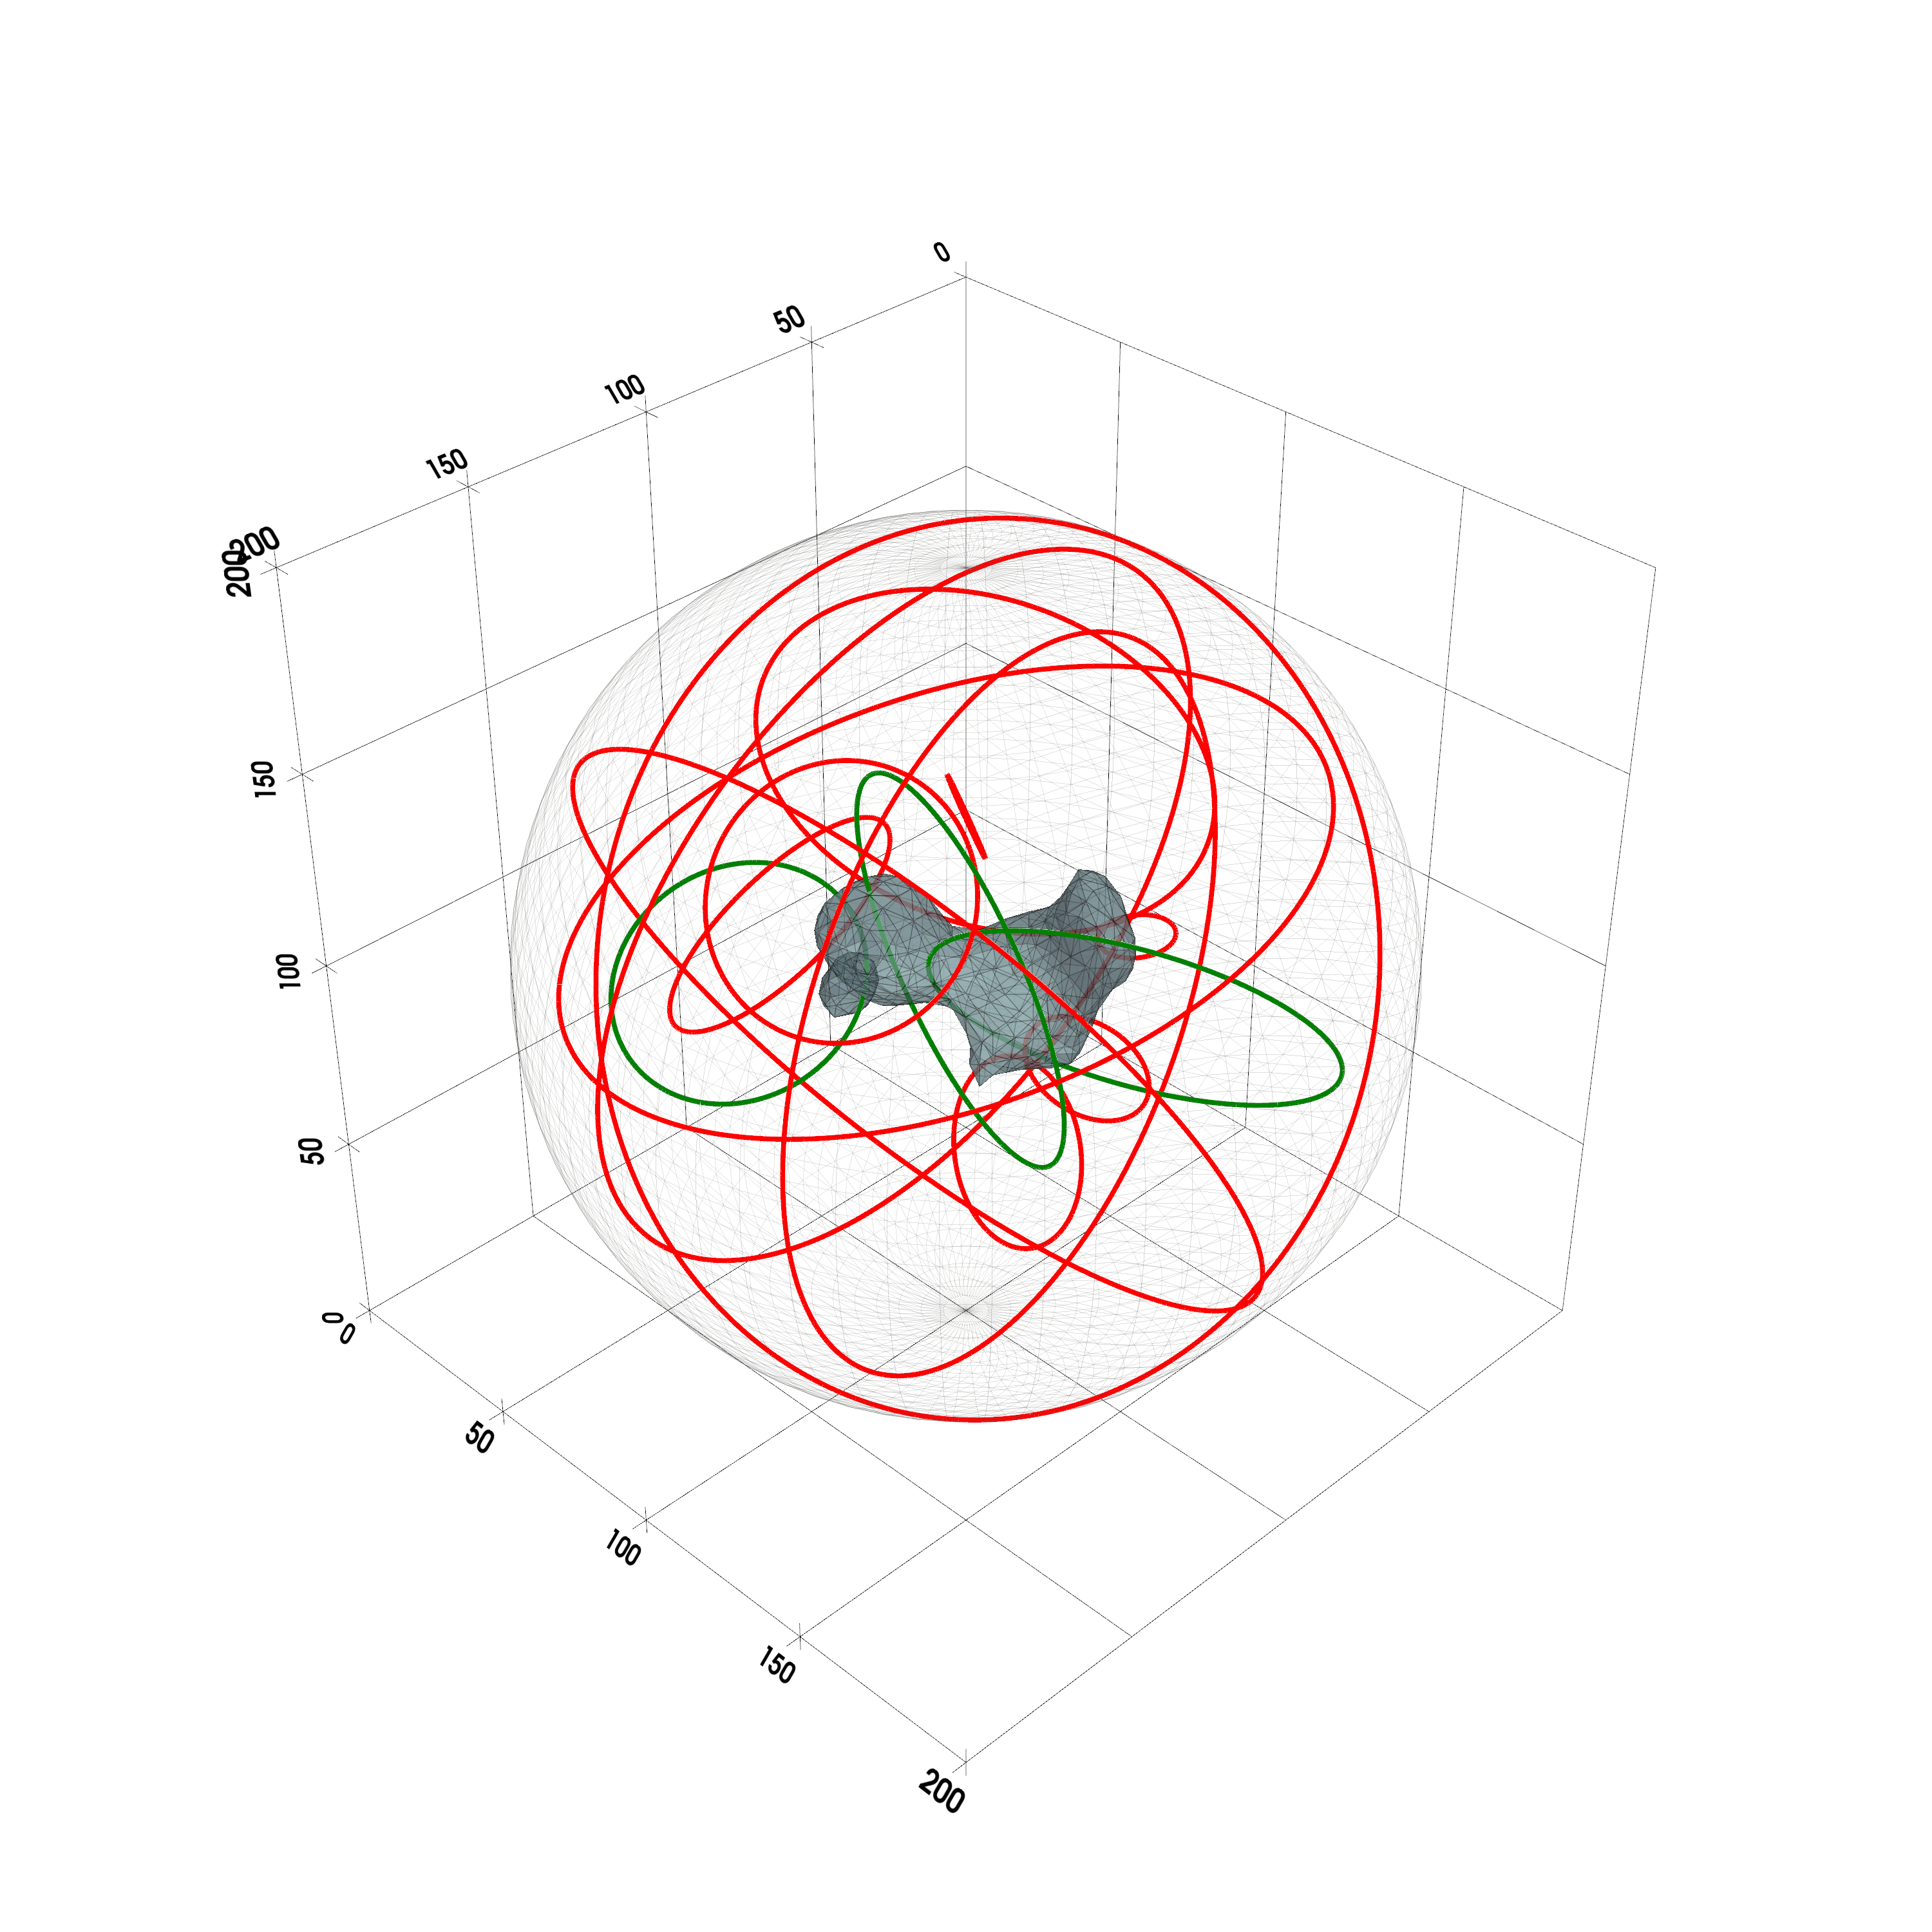

In [52]:
pv.start_xvfb()  

faces_flat = np.hstack(
    np.c_[np.full(len(face_simpl), 3), face_simpl]
).astype(np.int64)

mesh_pv = pv.PolyData(vert_simpl_scaled, faces=faces_flat)

plotter = pv.Plotter(off_screen=True, window_size=(1200, 1200))
plotter.set_background("white")

# Add main object (semi transparent) 
plotter.add_mesh(mesh_pv, color="lightblue", opacity=0.6, show_edges=True)

# Add enclosing sphere 
r = domain_max / 2
cx, cy, cz = domain_max / 2, domain_max / 2, domain_max / 2
sphere = pv.Sphere(radius=r, center=(cx, cy, cz), theta_resolution=60, phi_resolution=60)
plotter.add_mesh(sphere, color="grey", opacity=0.1, style="wireframe")

#  15 circles 
for i in range(15):
    circle = circle_points_global_list[i]
    color = "green" if yesno[i] == 1 else "red"
    # Ensure it’s a closed loop (wrap around)
    circle_closed = np.vstack([circle, circle[0]])
    plotter.add_lines(circle_closed, color=color, width=8, connected = True)

# Set camera
plotter.set_scale(1, 1, 1)
plotter.set_focus((domain_max / 2, domain_max / 2, domain_max / 2))
plotter.camera_position = [
    (domain_max * 2.8, domain_max * 2.8, domain_max * 2.8),  # camera position
    (domain_max / 2, domain_max / 2, domain_max / 2),        # focal point
    (0, 0, 1)                                                # view up
]

plotter.show_grid(
    color="black",
    xtitle=" ",
    ytitle=" ",
    ztitle=" ",
    font_size=38,
    grid=True,
    fmt="%.0f",
    location="outer"
)

plotter.show(screenshot="3Dshape_p1.png",window_size=(3000,3000),auto_close=True)


/rds/general/user/bk822/home/miniforge3/envs/test1/lib/python3.9/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(
/rds/general/user/bk822/home/miniforge3/envs/test1/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


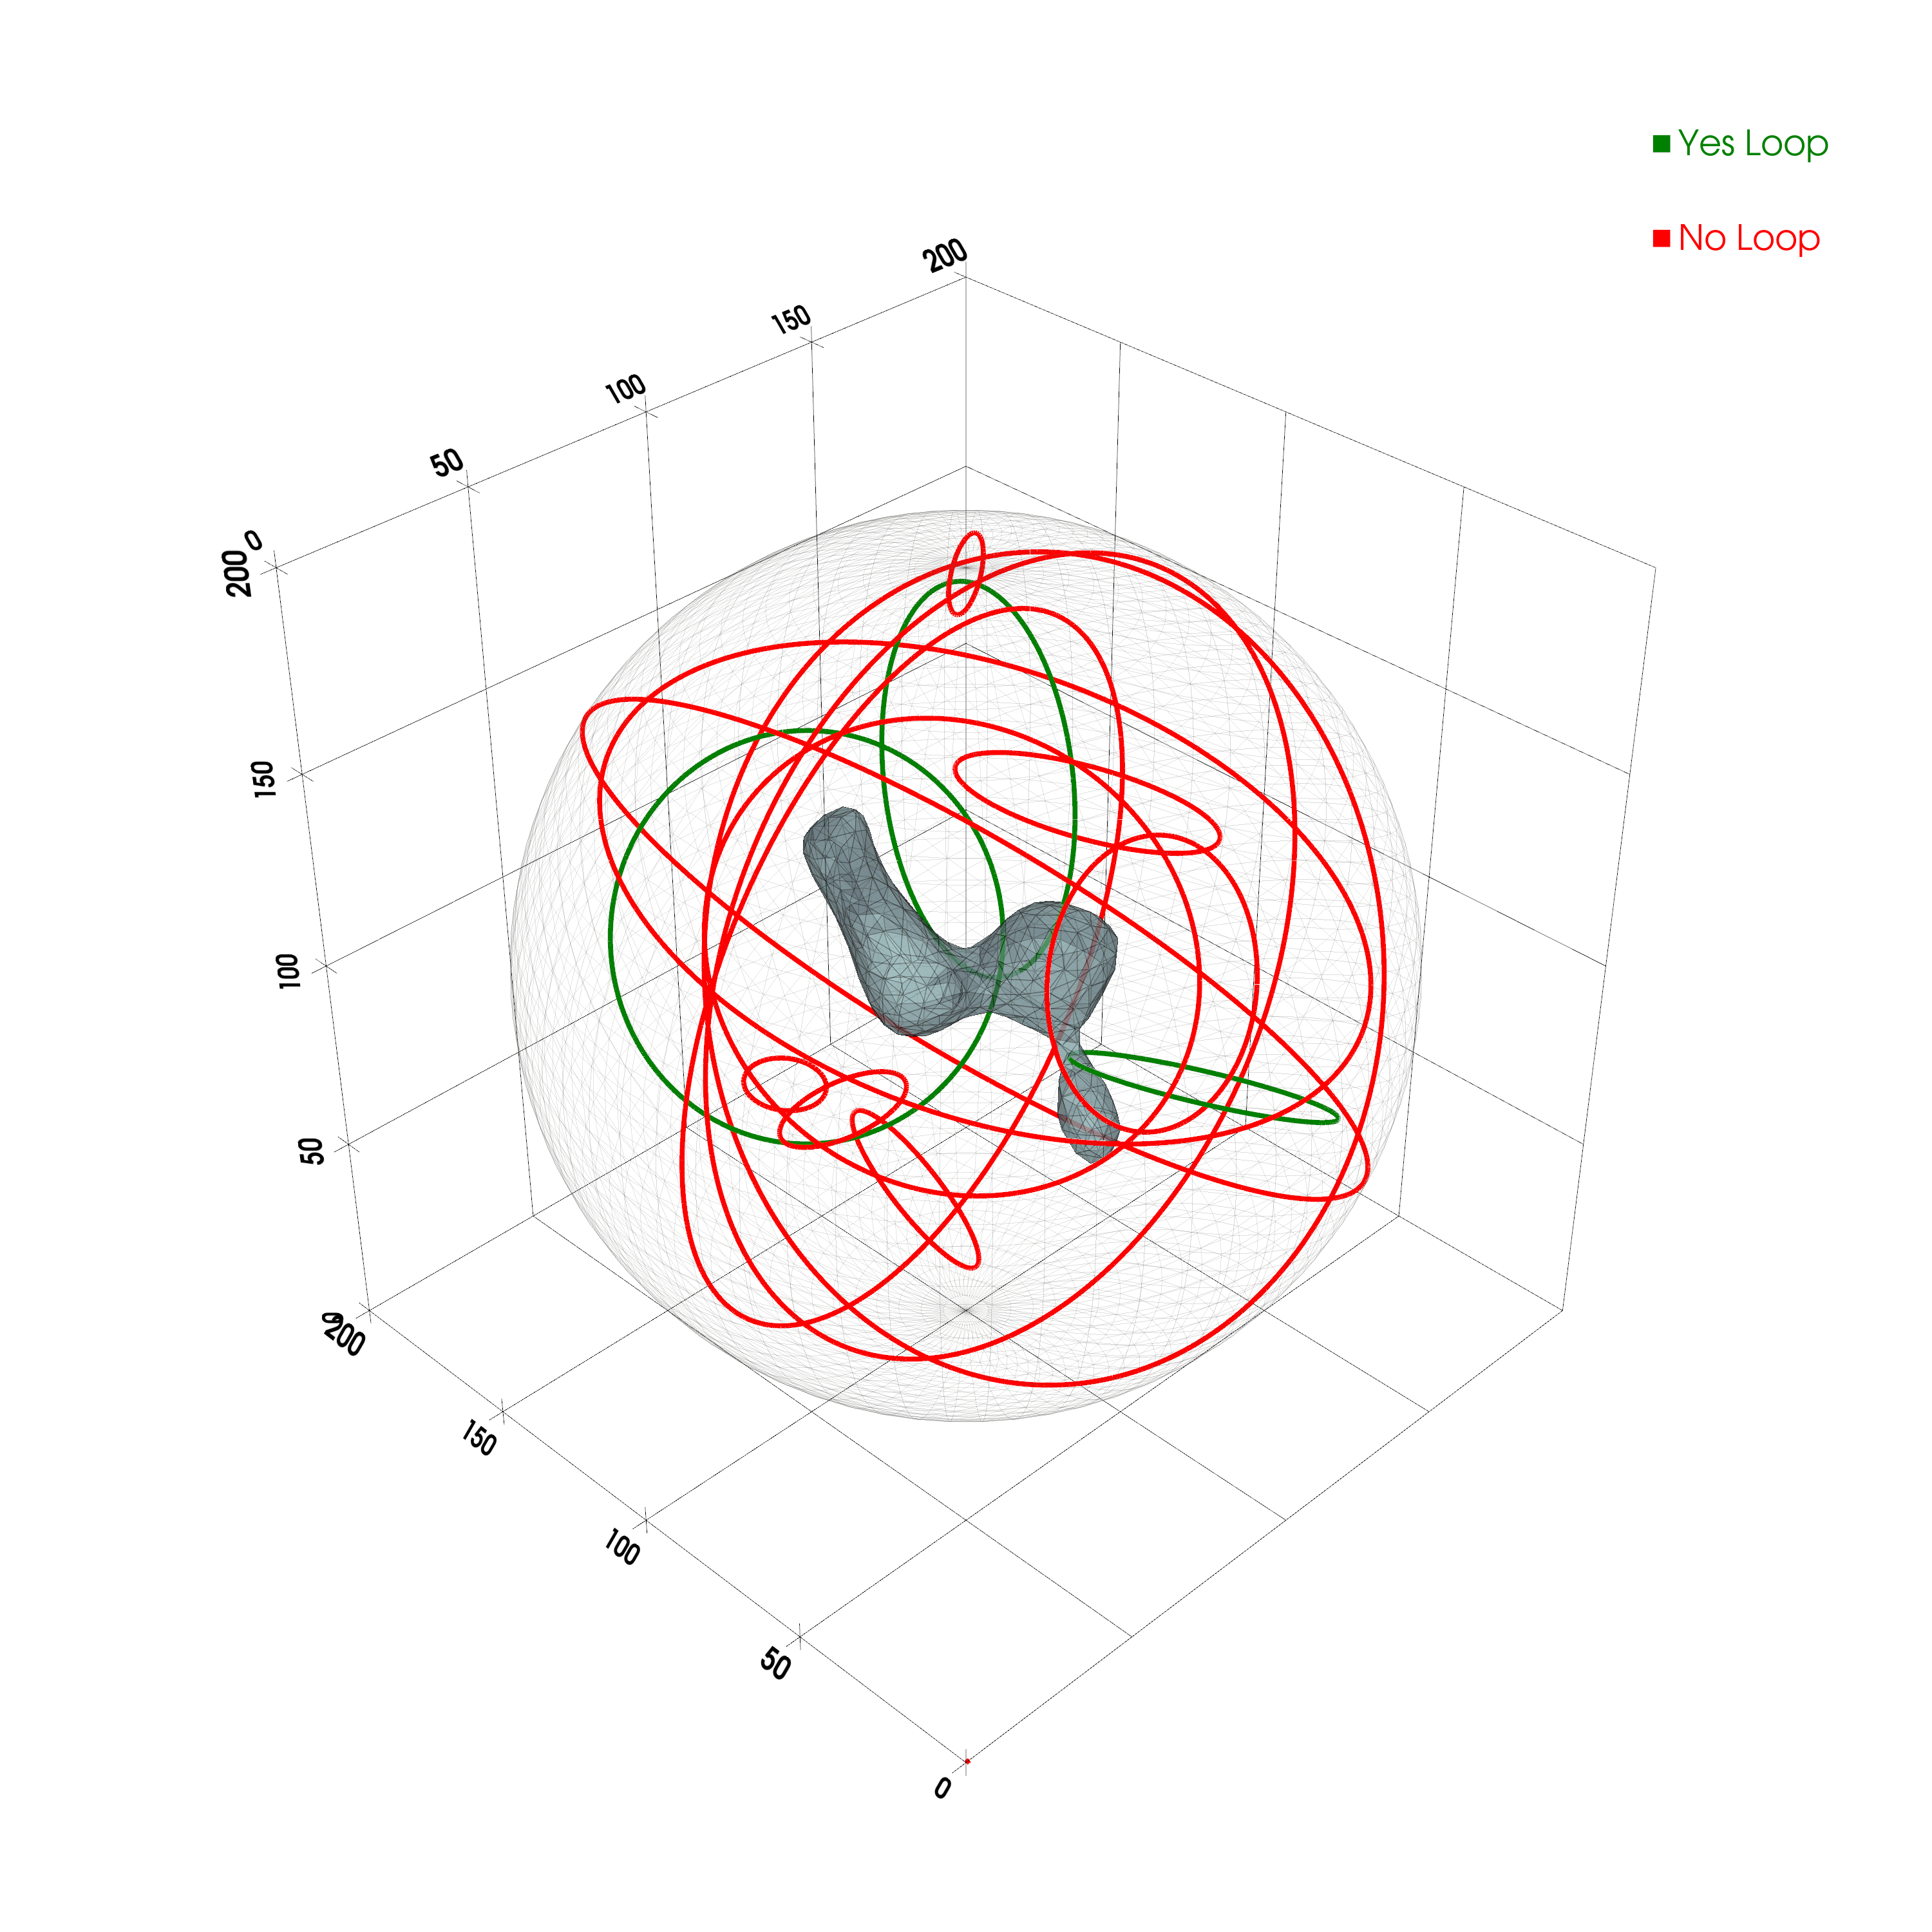

In [59]:

pv.start_xvfb()  

faces_flat = np.hstack(
    np.c_[np.full(len(face_simpl), 3), face_simpl]
).astype(np.int64)

mesh_pv = pv.PolyData(vert_simpl_scaled, faces=faces_flat)

plotter = pv.Plotter(off_screen=True, window_size=(1200, 1200))
plotter.set_background("white")

# Add main object (semi transparent)
plotter.add_mesh(mesh_pv, color="lightblue", opacity=0.6, show_edges=True)

# Add enclosing sphere 
r = domain_max / 2
cx, cy, cz = domain_max / 2, domain_max / 2, domain_max / 2
sphere = pv.Sphere(radius=r, center=(cx, cy, cz), theta_resolution=60, phi_resolution=60)
plotter.add_mesh(sphere, color="grey", opacity=0.1, style="wireframe")

# 15 circles
for i in range(15):
    circle = circle_points_global_list[i]
    color = "green" if yesno[i] == 1 else "red"
    # Ensure it’s a closed loop (wrap around)
    circle_closed = np.vstack([circle, circle[0]])
    plotter.add_lines(circle_closed, color=color, width=8, connected = True)
green_line = pv.Line((0, 0, 0), (1, 0, 0))
red_line = pv.Line((0, 0, 0), (1, 0, 0))

plotter.add_mesh(green_line, color="green", label="Intersection", line_width=8)
plotter.add_mesh(red_line, color="red", label="No Intersection", line_width=8)


plotter.add_legend(bcolor="white", border=False, face="rectangle", size=(0.1, 0.1))

# Set camera
plotter.set_scale(1, 1, 1)
plotter.set_focus((domain_max / 2, domain_max / 2, domain_max / 2))
cx, cy, cz = domain_max/2, domain_max/2, domain_max/2  
dx, dy, dz = domain_max * 2.8, domain_max * 2.8, domain_max * 2.8  


plotter.camera_position = [
    (2*cx - dx, 2*cy - dy, dz),
    (domain_max / 2, domain_max / 2, domain_max / 2),        
    (0, 0, 1)                                                
]

plotter.show_grid(
    color="black",
    xtitle=" ",
    ytitle=" ",
    ztitle=" ",
    font_size=38,
    grid=True,
    fmt="%.0f",
    location="outer"
)

plotter.show(screenshot="3Dshape_p2.png",window_size=(3000,3000),auto_close=True)

In [ ]:
# Simplify shapes with too many vertices
for i in range(len(fin_interior_components)):
    if len(fin_interior_components[i][1])>300:
        vertices, faces = fin_interior_components[i]
        print(i,"th object")
        mesh = o3d.geometry.TriangleMesh()
        mesh.vertices = o3d.utility.Vector3dVector(vertices)
        mesh.triangles = o3d.utility.Vector3iVector(faces)
        print("Before:", len(mesh.vertices), "vertices,", len(mesh.triangles), "faces")
        simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=700)
        print("After:", len(simplified.vertices), "vertices,", len(simplified.triangles), "faces")
        fin_interior_components[i] = (
            np.asarray(simplified.vertices),
            np.asarray(simplified.triangles)
        )

In [ ]:
nshapes_counter = 100
DOMAIN_MIN = 0
N_CIRCLES = 5000
n_cores = 8

encounter_dict = {i: [] for i in range(nshapes_counter)}
intersection_dict = {i: [] for i in range(nshapes_counter)}

# --- Worker function ---
def single_shape_worker(args):
    i, fin_interior_components, target_volume, domain_max = args
    vert_rand_choice, face_rand_choice = fin_interior_components[i]

    # Scale shape
    scale = (target_volume / mesh_volume(vert_rand_choice, face_rand_choice))**(1/3)
    vert_rand_choice = vert_rand_choice * scale
    shape_center = np.mean(vert_rand_choice, axis=0)

    intersect_count = 0
    fractions = []
    valid_circles = 0
    center_dom = np.array([domain_max/2, domain_max/2, domain_max/2])
    min_rad_dist, max_rad_dist = min_max_distance_to_center(vert_rand_choice, center=shape_center)
    max_length = max_distance_3d(vert_rand_choice)
    while valid_circles < N_CIRCLES:
        while True:
            if max_rad_dist > (domain_max/2):
                target_center = np.array([domain_max/2, domain_max/2, domain_max/2]) #To maximise area within the circle.#Still an underestimate
                translation = target_center - shape_center
                verts_rand_centered = vert_rand_choice + translation
                break 
            target_center = random_point_in_sphere(domain_max/2) + center_dom
            translation = target_center - shape_center
            verts_rand_centered = vert_rand_choice + translation
            if np.all(np.linalg.norm(verts_rand_centered - center_dom, axis=1) <= domain_max/2):
                break
        mesh = trimesh.Trimesh(vertices=verts_rand_centered, faces=face_rand_choice, process=False)    
        r = np.random.uniform(1, (domain_max/2)*0.9999)
        normal = np.random.normal(size=3)
        normal /= np.linalg.norm(normal)
        if abs(normal[0]) < 0.9:
            tangent = np.cross(normal, [1, 0, 0])
        else:
            tangent = np.cross(normal, [0, 1, 0])
        tangent /= np.linalg.norm(tangent)
        bitangent = np.cross(normal, tangent)

        n_points = int(np.ceil(2 * np.pi * r))
        if n_points == 0:
            continue

        angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
        circle_points_local = (
            np.outer(np.cos(angles), tangent) +
            np.outer(np.sin(angles), bitangent)
        ) * r

        radius_limit = np.sqrt((domain_max/2)**2-r**2)
        while True:
            center_offset = random_point_in_sphere(radius_limit)
            center = center_dom + center_offset
            circle_points_global = circle_points_local + center 
            distances = np.linalg.norm(circle_points_global - center_dom, axis=1)
            if np.any(distances > domain_max/2):
                continue
            break
        inside = mesh.contains(circle_points_global)
        num_inside = np.count_nonzero(inside)
        if num_inside > 0:
            intersect_count += 1 #Number of intersections
            fractions.append(num_inside / n_points) #Encounter rate per circle
        valid_circles = valid_circles+1

    mean_frac = np.mean(fractions) if fractions else 0.0 #Average encounter rate
    return i, intersect_count, mean_frac

# --- Parameter sweep ---
space_size = np.append(np.arange(17.5, 400, 20), 400) * 2
for i_space, domain_max in enumerate(space_size):
    args_list = [(i, fin_interior_components, target_volume, domain_max)
                 for i in range(len(fin_interior_components))]

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = {executor.submit(single_shape_worker, args): args[0] for args in args_list}

        with tqdm(total=len(futures),
                  desc=f"Processing shapes for domain={domain_max}",
                  unit="shape") as pbar:
            for future in as_completed(futures):
                idx_shape = futures[future]
                try:
                    i_shape, intersect_count, mean_frac = future.result()
                    intersection_dict[i_shape].append(intersect_count)
                    encounter_dict[i_shape].append(mean_frac)
                except Exception as e:
                    print(f"Shape {idx_shape} failed with error: {e}")
                pbar.update(1)

with open('3D_turing_circles_encounter.pickle', 'wb') as handle:
    pickle.dump(encounter_dict,handle)

with open('3D_turing_circles_intersection.pickle', 'wb') as handle:
   pickle.dump(intersection_dict,handle)

with open('3D_turing_circles_intersection.pickle', 'rb') as handle:
    intersection_dict = pickle.load(handle)
with open('3D_turing_circles_encounter.pickle', 'rb') as handle:
    encounter_dict = pickle.load(handle)
mean_encounter_3D = []

for size in range(len(encounter_dict[0])):
    encounter_tmp = []
    for sh in encounter_dict:
        encounter_tmp.append(encounter_dict[sh][size])
    mean_encounter_3D.append(np.mean(encounter_tmp))
    

mean_intersect_3D = []
for size in range(len(intersection_dict[0])):
    intersect_tmp = []
    for sh in intersection_dict:
        intersect_tmp.append(intersection_dict[sh][size])
    mean_intersect_3D.append(np.mean(intersect_tmp))


In [ ]:

# === Configuration ===
nshapes_counter = 100
DOMAIN_MIN = 0
N_ELLIPSES = 5000
n_cores = 8  

oval_encounter_dict = {i: [] for i in range(nshapes_counter)}
oval_intersection_dict = {i: [] for i in range(nshapes_counter)}

# --- Worker function ---
def single_shape_worker(args):
    i, fin_interior_components, target_volume, domain_max = args
    vert_rand_choice, face_rand_choice = fin_interior_components[i]

    # Scale shape
    scale = (target_volume / mesh_volume(vert_rand_choice, face_rand_choice))**(1/3)
    vert_rand_choice = vert_rand_choice * scale
    shape_center = np.mean(vert_rand_choice, axis=0)

    intersect_count = 0
    fractions = []

    valid_ellipses = 0
    
    center_dom = np.array([domain_max/2, domain_max/2, domain_max/2])
    min_rad_dist, max_rad_dist = min_max_distance_to_center(vert_rand_choice, center=shape_center)
    max_length = max_distance_3d(vert_rand_choice)
    while valid_ellipses < N_ELLIPSES:
        while True:
            if max_rad_dist > (domain_max/2):
                target_center = np.array([domain_max/2, domain_max/2, domain_max/2]) #To maximise area within the circle.#Still an underestimate
                translation = target_center - shape_center
                verts_rand_centered = vert_rand_choice + translation
                break 
            target_center = random_point_in_sphere(domain_max/2) + center_dom
            translation = target_center - shape_center
            verts_rand_centered = vert_rand_choice + translation
            if np.all(np.linalg.norm(verts_rand_centered - center_dom, axis=1) <= domain_max/2):
                break
        mesh = trimesh.Trimesh(vertices=verts_rand_centered, faces=face_rand_choice, process=False)    
        a = np.random.uniform(1, (domain_max/2)*0.9999)
        b = np.random.uniform(1, (domain_max/2)*0.9999)  
        
        normal = np.random.normal(size=3)
        normal /= np.linalg.norm(normal)
        
        if abs(normal[0]) < 0.9:
            tangent = np.cross(normal, [1, 0, 0])
        else:
            tangent = np.cross(normal, [0, 1, 0])
        
        tangent /= np.linalg.norm(tangent)
        bitangent = np.cross(normal, tangent)
        perimeter_est = np.pi * (3*(a+b) - np.sqrt((3*a + b)*(a + 3*b)))
        n_points = int(np.ceil(perimeter_est))
        
        # --- Oversample ellipse in angle space ---
        N_high = n_points*10  # oversample for good arc-length resolution
        theta = np.linspace(0, 2*np.pi, N_high, endpoint=False)
        pts = np.outer(np.cos(theta), tangent) * a + np.outer(np.sin(theta), bitangent) * b
        
        # --- Compute cumulative distances along perimeter ---
        d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
        cum = np.concatenate([[0.], np.cumsum(d)])
        total_length = cum[-1]
        
        target_dist = np.linspace(0, total_length, n_points, endpoint=False)
        theta_equal = np.interp(target_dist, cum[:-1], theta)
        ellipse_points_local = np.outer(np.cos(theta_equal), tangent) * a + \
                               np.outer(np.sin(theta_equal), bitangent) * b

        radius_limit = np.sqrt((domain_max/2)**2 - np.max((a, b))**2)

        while True:
            center_offset = random_point_in_sphere(radius_limit)
            center = center_dom + center_offset
            ellipse_points_global = ellipse_points_local + center 
            distances = np.linalg.norm(ellipse_points_global - center_dom, axis=1)
            if np.any(distances > domain_max/2):
                continue
            break


        # Test intersection with shape
        inside = mesh.contains(ellipse_points_global)
        num_inside = np.count_nonzero(inside)
        if num_inside > 0:
            intersect_count += 1
            fractions.append(num_inside / n_points)
        valid_ellipses += 1
    mean_frac = np.mean(fractions) if fractions else 0.0
    return i, intersect_count, mean_frac

# --- Parameter sweep ---
space_size = np.append(np.arange(17.5, 400, 20), 400) * 2
print(space_size)

for i_space, domain_max in enumerate(space_size):
    args_list = [(i, fin_interior_components, target_volume, domain_max)
                 for i in range(len(fin_interior_components))]

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = {executor.submit(single_shape_worker, args): args[0] for args in args_list}

        with tqdm(total=len(futures),
                  desc=f"Processing shapes for domain={domain_max}",
                  unit="shape") as pbar:
            for future in as_completed(futures):
                idx_shape = futures[future]
                try:
                    i_shape, intersect_count, mean_frac = future.result()
                    oval_intersection_dict[i_shape].append(intersect_count)
                    oval_encounter_dict[i_shape].append(mean_frac)
                except Exception as e:
                    print(f"Shape {idx_shape} failed with error: {e}")
                pbar.update(1)
with open('3D_turing_oval_encounter.pickle', 'wb') as handle:
    pickle.dump(oval_encounter_dict,handle)

with open('3D_turing_oval_intersection.pickle', 'wb') as handle:
   pickle.dump(oval_intersection_dict,handle)

with open('3D_turing_oval_intersection.pickle', 'rb') as handle:
    oval_intersection_dict = pickle.load(handle)
with open('3D_turing_oval_encounter.pickle', 'rb') as handle:
    oval_encounter_dict = pickle.load(handle)
    
oval_mean_encounter_3D = []

for size in range(len(oval_encounter_dict[0])):
    encounter_tmp = []
    for sh in oval_encounter_dict2:
        encounter_tmp.append(oval_encounter_dict[sh][size])
    oval_mean_encounter_3D.append(np.mean(encounter_tmp))
    

oval_mean_intersect_3D = []
for size in range(len(oval_intersection_dict[0])):
    intersect_tmp = []
    for sh in oval_intersection_dict:
        intersect_tmp.append(oval_intersection_dict[sh][size])
    oval_mean_intersect_3D.append(np.mean(intersect_tmp))


In [ ]:
nshapes_counter = 100
DOMAIN_MIN = 0
N_ELLIPSES = 5000
n_cores = 8  

uni_oval_encounter_dict = {i: [] for i in range(nshapes_counter)}
uni_oval_intersection_dict = {i: [] for i in range(nshapes_counter)}

def sample_uniform_r_ovals(large_radius):
    min_radius = 1
    max_radius = large_radius
    
    r = np.random.uniform(1, 10)

    ry_min = np.maximum(min_radius, min_radius / r)
    ry_max = np.minimum(max_radius, max_radius / r)

    ry = np.random.uniform(ry_min, ry_max)
    rx = r * ry
    return rx, ry
        
# --- Worker function ---
def single_shape_worker(args):
    i, fin_interior_components, target_volume, domain_max = args
    vert_rand_choice, face_rand_choice = fin_interior_components[i]

    # Scale shape
    scale = (target_volume / mesh_volume(vert_rand_choice, face_rand_choice))**(1/3)
    vert_rand_choice = vert_rand_choice * scale

    # Center shape
    shape_center = np.mean(vert_rand_choice, axis=0)
    
    intersect_count = 0
    fractions = []
    valid_ellipses = 0
    center_dom = np.array([domain_max/2, domain_max/2, domain_max/2])
    min_rad_dist, max_rad_dist = min_max_distance_to_center(vert_rand_choice, center=shape_center)
    max_length = max_distance_3d(vert_rand_choice)
    while valid_ellipses < N_ELLIPSES:
        while True:
            if max_rad_dist > (domain_max/2):
                target_center = np.array([domain_max/2, domain_max/2, domain_max/2]) #To maximise area within the circle.#Still an underestimate
                translation = target_center - shape_center
                verts_rand_centered = vert_rand_choice + translation
                break 
            target_center = random_point_in_sphere(domain_max/2) + center_dom
            translation = target_center - shape_center
            verts_rand_centered = vert_rand_choice + translation
            if np.all(np.linalg.norm(verts_rand_centered - center_dom, axis=1) <= domain_max/2):
                break
        mesh = trimesh.Trimesh(vertices=verts_rand_centered, faces=face_rand_choice, process=False) 
        a,b = sample_uniform_r_ovals(domain_max/2)
        
        normal = np.random.normal(size=3)
        normal /= np.linalg.norm(normal)
        
        if abs(normal[0]) < 0.9:
            tangent = np.cross(normal, [1, 0, 0])
        else:
            tangent = np.cross(normal, [0, 1, 0])
        
        tangent /= np.linalg.norm(tangent)
        bitangent = np.cross(normal, tangent)
        perimeter_est = np.pi * (3*(a+b) - np.sqrt((3*a + b)*(a + 3*b)))
        n_points = int(np.ceil(perimeter_est))
        
        # --- Oversample ellipse in angle space ---
        N_high = n_points*10  # oversample for good arc-length resolution
        theta = np.linspace(0, 2*np.pi, N_high, endpoint=False)
        pts = np.outer(np.cos(theta), tangent) * a + np.outer(np.sin(theta), bitangent) * b
        
        # --- Compute cumulative distances along perimeter ---
        d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
        cum = np.concatenate([[0.], np.cumsum(d)])
        total_length = cum[-1]
        
        target_dist = np.linspace(0, total_length, n_points, endpoint=False)
        theta_equal = np.interp(target_dist, cum[:-1], theta)
        ellipse_points_local = np.outer(np.cos(theta_equal), tangent) * a + \
                               np.outer(np.sin(theta_equal), bitangent) * b

        # Choose center ensuring entire ellipse fits in domain
        radius_limit = np.sqrt((domain_max/2)**2 - np.max((a, b))**2)
        while True:
            center_offset = random_point_in_sphere(radius_limit)
            center = center_dom + center_offset
            ellipse_points_global = ellipse_points_local + center 
            distances = np.linalg.norm(ellipse_points_global - center_dom, axis=1)
            if np.any(distances > domain_max/2):
                continue
            break

        # Test intersection with shape
        inside = mesh.contains(ellipse_points_global)
        num_inside = np.count_nonzero(inside)
        if num_inside > 0:
            intersect_count += 1
            fractions.append(num_inside / n_points)
        valid_ellipses += 1
    mean_frac = np.mean(fractions) if fractions else 0.0
    return i, intersect_count, mean_frac

# --- Parameter sweep ---
space_size = np.append(np.arange(17.5, 400, 20), 400) * 2
print(space_size)

for i_space, domain_max in enumerate(space_size):
    args_list = [(i, fin_interior_components, target_volume, domain_max)
                 for i in range(len(fin_interior_components))]

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = {executor.submit(single_shape_worker, args): args[0] for args in args_list}

        with tqdm(total=len(futures),
                  desc=f"Processing shapes for domain={domain_max}",
                  unit="shape") as pbar:
            for future in as_completed(futures):
                idx_shape = futures[future]
                try:
                    i_shape, intersect_count, mean_frac = future.result()
                    uni_oval_intersection_dict[i_shape].append(intersect_count)
                    uni_oval_encounter_dict[i_shape].append(mean_frac)
                except Exception as e:
                    print(f"Shape {idx_shape} failed with error: {e}")
                pbar.update(1)
with open('3D_turing_uni_oval_encounter.pickle', 'wb') as handle:
    pickle.dump(uni_oval_encounter_dict,handle)

with open('3D_turing_uni_oval_intersection.pickle', 'wb') as handle:
    pickle.dump(uni_oval_intersection_dict,handle)

with open('3D_turing_uni_oval_intersection.pickle', 'rb') as handle:
    uni_oval_intersection_dict = pickle.load(handle)
with open('3D_turing_uni_oval_encounter.pickle', 'rb') as handle:
    uni_oval_encounter_dict = pickle.load(handle)
uni_oval_mean_encounter_3D = []

for size in range(len(uni_oval_encounter_dict[0])):
    encounter_tmp = []
    for sh in uni_oval_encounter_dict:
        encounter_tmp.append(uni_oval_encounter_dict[sh][size])
    uni_oval_mean_encounter_3D.append(np.mean(encounter_tmp))
    

uni_oval_mean_intersect_3D = []
for size in range(len(uni_oval_intersection_dict[0])):
    intersect_tmp = []
    for sh in uni_oval_intersection_dict:
        intersect_tmp.append(uni_oval_intersection_dict[sh][size])
    uni_oval_mean_intersect_3D.append(np.mean(intersect_tmp))


In [ ]:

# === Configuration ===
nshapes_counter = 100
DOMAIN_MIN = 0
N_points = 50000
n_cores = 8  



    
point_encounter_dict = {i: [] for i in range(nshapes_counter)}
point_intersection_dict = {i: [] for i in range(nshapes_counter)}

# --- Worker function ---
def single_shape_worker(args):
    i, fin_interior_components, target_volume, domain_max = args
    vert_rand_choice, face_rand_choice = fin_interior_components[i]

    # Scale shape
    scale = (target_volume / mesh_volume(vert_rand_choice, face_rand_choice))**(1/3)
    vert_rand_choice = vert_rand_choice * scale
    
    shape_center = np.mean(vert_rand_choice, axis=0)

    # Center shape
    center_dom = np.array([domain_max/2]*3)
    min_rad_dist, max_rad_dist = min_max_distance_to_center(vert_rand_choice, center=shape_center)
    max_length = max_distance_3d(vert_rand_choice)
    intersect_count = 0
    for _ in range(10000):
        while True:
            if max_rad_dist > (domain_max/2):
                target_center = np.array([domain_max/2, domain_max/2, domain_max/2]) #To maximise area within the circle.#Still an underestimate
                translation = target_center - shape_center
                verts_rand_centered = vert_rand_choice + translation
                break 
            target_center = random_point_in_sphere(domain_max/2) + center_dom
            translation = target_center - shape_center
            verts_rand_centered = vert_rand_choice + translation
            if np.all(np.linalg.norm(verts_rand_centered - center_dom, axis=1) <= domain_max/2):
                break
        mesh = trimesh.Trimesh(vertices=verts_rand_centered, faces=face_rand_choice, process=False) 
        
        radius = domain_max / 2
        point = (random_point_in_sphere(radius)+center_dom).reshape(1, 3)  # reshape here
        inside = mesh.contains(point)[0]
        if inside == 1:
            intersect_count = intersect_count+1
    return i, intersect_count


# --- Parameter sweep ---
space_size = np.append(np.arange(17.5, 400, 20), 400) * 2
print(space_size)

for i_space, domain_max in enumerate(space_size):
    args_list = [(i, fin_interior_components, target_volume, domain_max)
                 for i in range(len(fin_interior_components))]

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = {executor.submit(single_shape_worker, args): args[0] for args in args_list}

        with tqdm(total=len(futures),
                  desc=f"Processing shapes for domain={domain_max}",
                  unit="shape") as pbar:
            for future in as_completed(futures):
                idx_shape = futures[future]
                try:
                    i_shape, intersect_count = future.result()
                    point_encounter_dict[i_shape].append(intersect_count)
                except Exception as e:
                    print(f"Shape {idx_shape} failed with error: {e}")
                pbar.update(1)
with open('3D_turing_point_encounter.pickle', 'wb') as handle:
    pickle.dump(point_encounter_dict,handle)

with open('3D_turing_point_encounter.pickle', 'rb') as handle:
    point_encounter_dict = pickle.load(handle)

point_mean_encounter_3D = []

for size in range(len(point_encounter_dict[0])):
    encounter_tmp = []
    for sh in point_encounter_dict:
        encounter_tmp.append(point_encounter_dict[sh][size])
    point_mean_encounter_3D.append(np.mean(encounter_tmp))
    

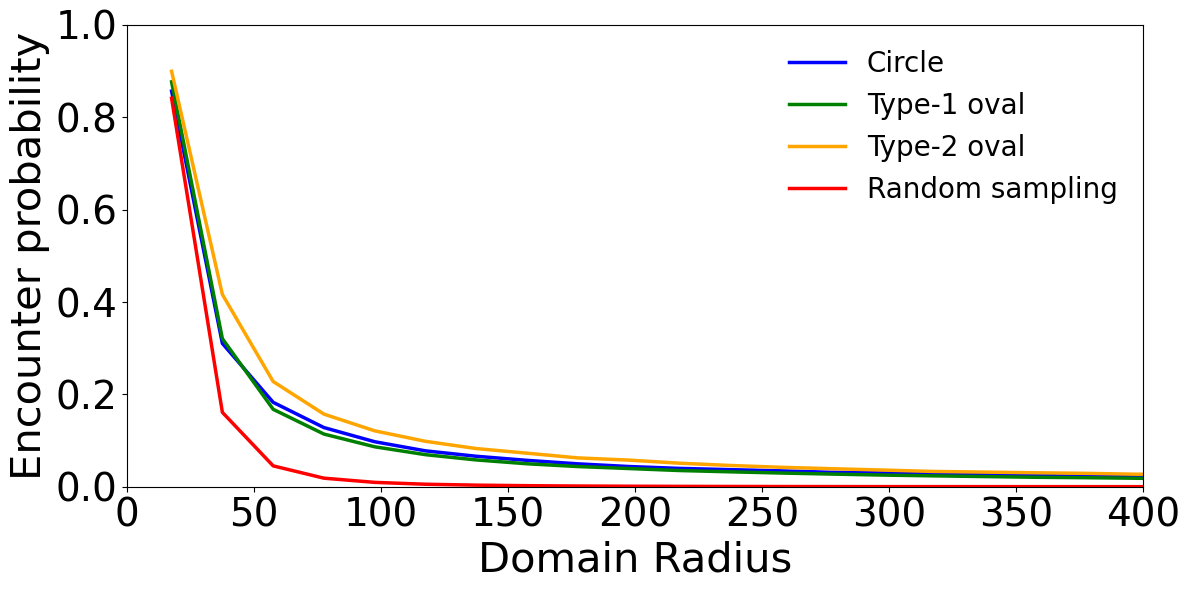

In [22]:
plt.figure(figsize = (12,6))

plt.plot(np.append(np.arange(17.5, 400, 20),400),mean_encounter_3D,color = "blue", linewidth=2.5, label = "Circle")
plt.plot(np.append(np.arange(17.5, 400, 20),400),oval_mean_encounter_3D,color = "green", linewidth=2.5, label = "Type-1 oval")
plt.plot(np.append(np.arange(17.5, 400, 20),400),uni_oval_mean_encounter_3D,color = "orange",linewidth=2.5, label = "Type-2 oval")
plt.plot(np.append(np.arange(17.5, 400, 20),400),np.divide(point_mean_encounter_3D,10000),color = "red", linewidth=2.5, label = "Random sampling")
#point_enc = [target_volume]*21
rads = np.append(np.arange(17.5, 400, 20),400)
vol = 4*rads*rads*rads*np.pi/3
#plt.plot(np.append(np.arange(17.5, 400, 20),400),np.divide(point_enc,vol),color = "black", linewidth=2.5)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Domain Radius",fontsize = 30)
plt.ylabel("Encounter probability",fontsize = 30)

plt.ylim(0, 1)
plt.xlim(0, 400)
#plt.axvline(20)
plt.legend(fontsize=20,frameon=False)
plt.tight_layout()
plt.savefig("3D_Turing_encounter.png")
plt.show()

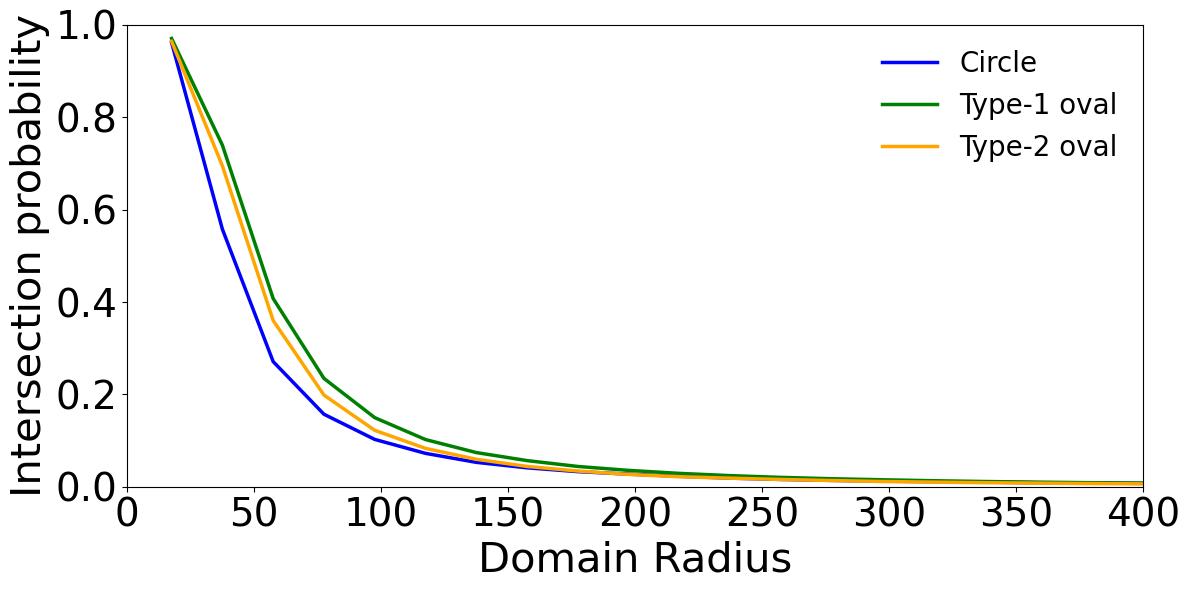

In [23]:
plt.figure(figsize = (12,6))
plt.plot(np.append(np.arange(17.5, 400, 20),400), np.divide(mean_intersect_3D,5000),color = "blue", label = "Circle",linewidth=2.5)
plt.plot(np.append(np.arange(17.5, 400, 20),400), np.divide(oval_mean_intersect_3D,5000),color = "green", label = "Type-1 oval",linewidth=2.5)
plt.plot(np.append(np.arange(17.5, 400, 20),400), np.divide(uni_oval_mean_intersect_3D,5000),color = "orange", label = "Type-2 oval",linewidth=2.5)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Domain Radius",fontsize = 30)
plt.ylabel("Intersection probability",fontsize = 30)

plt.ylim(0, 1)
plt.xlim(0, 400)
plt.legend(fontsize=20,frameon=False)
plt.tight_layout()
plt.savefig("3D_Turing_intersect_randloc.png")
plt.show()

In [ ]:
space_size = [600]
intersection_hist = []
encounter_hist = []
sph_list_hist = []
def sphericity_calc(verts, faces): 
    A = mesh_area(verts, faces) 
    V = mesh_volume(verts, faces) 
    sphericity = (np.pi ** (1/3)) * ((6 * V) ** (2/3)) / A 
    return sphericity
for i_space, domain_max in enumerate(space_size):
    args_list = [(i, fin_interior_components, target_volume, domain_max)
                 for i in range(len(fin_interior_components))]

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = {executor.submit(single_shape_worker, args): args[0] for args in args_list}

        with tqdm(total=len(futures),
                  desc=f"Processing shapes for domain={domain_max}",
                  unit="shape") as pbar:
            for future in as_completed(futures):
                idx_shape = futures[future]
                try:
                    i_shape, intersect_count_hist, mean_frac_hist = future.result()
                    intersection_hist.append(intersect_count_hist)
                    encounter_hist.append(mean_frac_hist)
                    sph_list_hist.append(
                        sphericity_calc(fin_interior_components[i_shape][0], fin_interior_components[i_shape][1])
                    )
                except Exception as e:
                    print(f"Shape {idx_shape} failed with error: {e}")
                pbar.update(1)
df = pd.read_excel("3D_shape_results_mov_cent.xlsx")


1000


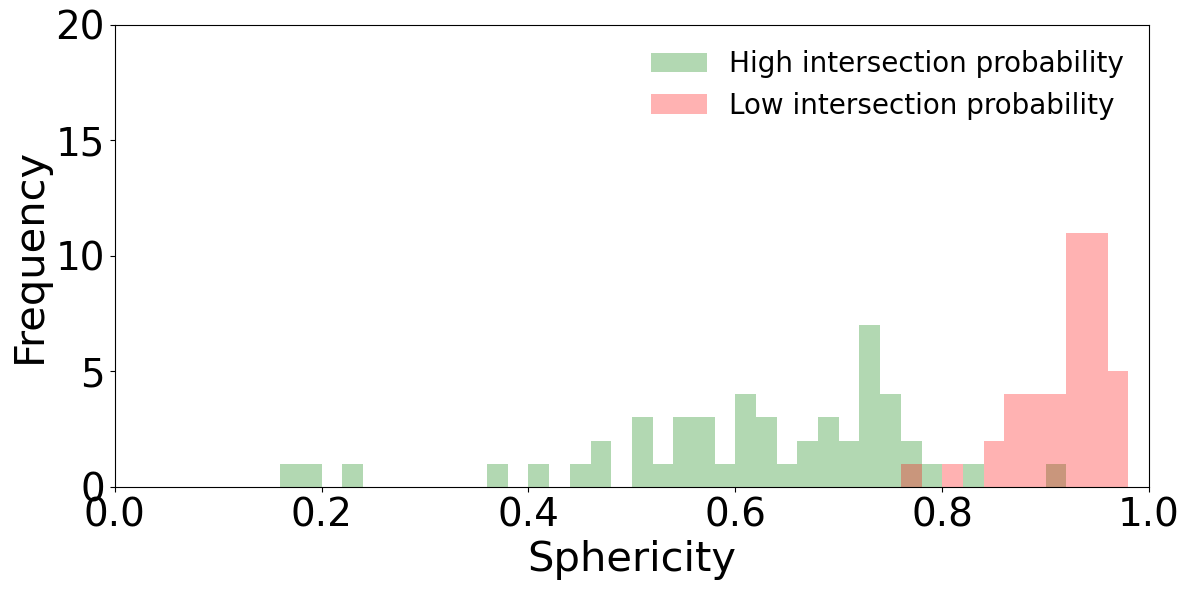

In [11]:
n_runs = 1000
top_inter = df.sort_values(by='intersection_ratios', ascending=False).head(int(n_runs*0.05))
bottom_inter = df.sort_values(by='intersection_ratios', ascending=True).head(int(n_runs*0.05))
print(len(df))
# Plotting
bins = np.linspace(0, 1, 51)
plt.figure(figsize=(12, 6))
plt.hist(top_inter['sphericity'], bins=bins, alpha=0.3, label=f'High intersection probability', color='green')
plt.hist(bottom_inter['sphericity'], bins=bins, alpha=0.3, label=f'Low intersection probability', color='red')
plt.xlabel('Sphericity', fontsize = 30)
plt.ylabel('Frequency', fontsize =30)
plt.ylim(0,20)
plt.legend(fontsize =20,frameon=False)
plt.xticks(fontsize=28)
plt.yticks([0,5,10,15,20],fontsize=28)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("3Dsupp_distribution_mov_cent.png")
plt.show()

# Supplementary Figure 5F.
The readers are required to have run Figure_3.ipynb and hold the file
"all_res_2Dmovingcent.pkl"
   

In [ ]:
with open("all_res_2Dmovingcent.pkl", "rb") as f:
    all_results = pickle.load(f) #load it as all results again
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
sines = np.sin(np.linspace(0,np.pi*2,100))
cosines = np.cos(np.linspace(0,np.pi*2,100))
sines2 = np.sin(np.linspace(0,np.pi*2,30))
cosines2 = np.cos(np.linspace(0,np.pi*2,30))
inset_dict = {"circle_intersect_ratio":[sines, cosines],
              "uni_oval_intersect_ratio":[sines, cosines*0.3],
              "norm_oval_intersect_ratio":[sines, cosines*0.7],
              "circle_hit_ratio":[sines2, cosines2],
              "uni_oval_hit_ratio":[sines2, cosines2*0.3],
              "norm_oval_hit_ratio":[sines2, cosines2*0.7],
              "cloud_hit_ratio":[np.random.uniform(-1,1,30), np.random.uniform(-1,1,30)]}

metrics = [
    ("circle_intersect_ratio", "Circle \n intersection probability"),
    ("uni_oval_intersect_ratio", "Uniform-oval \n intersection probability"),
    ("norm_oval_intersect_ratio", "Oval \n intersection probability"),
    ("circle_hit_ratio", "Circle \n encounter probability"),
    ("uni_oval_hit_ratio", "Uniform-oval \n encounter probability"),
    ("norm_oval_hit_ratio", "Oval \n encounter probability"),
    ("cloud_hit_ratio", "Random sampling \n encounter probability"),
]
vals_2D = {}
for metric_key, metric_label in metrics:
    # Extract all values for this metric across shapes
    metric_matrix = np.array([[r[metric_key] for r in shape_result] for shape_result in all_results])
    avg_values = np.mean(metric_matrix, axis=0)
    print(metric_key)
    if metric_key not in vals_2D:
        vals_2D[metric_key] = []
    vals_2D[metric_key].append(avg_values)
    # Plot the average line
    plt.plot(radii, avg_values, label=metric_label, linewidth=2.5)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)

/var/tmp/pbs.1220840.pbs-7/ipykernel_868426/878621243.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(fontsize=20,frameon=False)


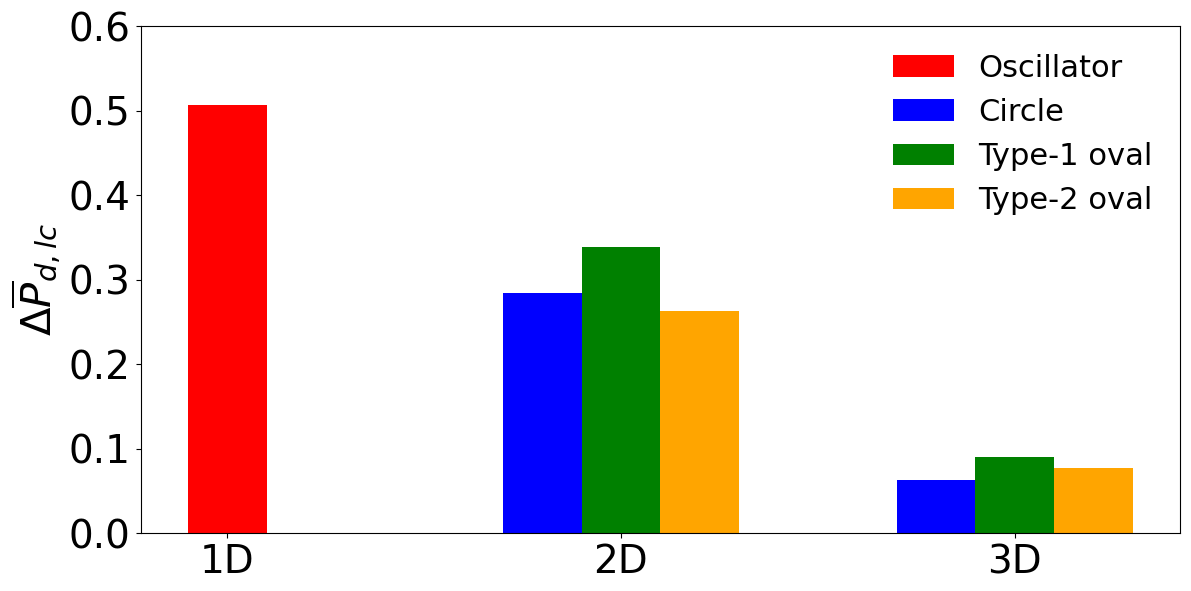

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean values

mean_1D = np.mean(np.subtract(intersection_list_1D, point_list_1D))

mean_2D_circle = np.mean(np.subtract(vals_2D['circle_intersect_ratio'], vals_2D['cloud_hit_ratio']))
mean_2D_oval = np.mean(np.subtract(vals_2D['norm_oval_intersect_ratio'], vals_2D['cloud_hit_ratio']))
mean_2D_uni = np.mean(np.subtract(vals_2D['uni_oval_intersect_ratio'], vals_2D['cloud_hit_ratio']))

mean_3D_circle = np.mean(np.subtract(mean_intersect2_3D, point_mean_encounter_3D))
mean_3D_oval = np.mean(np.subtract(oval_mean_intersect2_3D, point_mean_encounter_3D))
mean_3D_uni = np.mean(np.subtract(uni_oval_mean_intersect2_3D, point_mean_encounter_3D))

# Group the values
values = [
    [mean_1D],  # 1D group
    [mean_2D_circle, mean_2D_oval, mean_2D_uni],  # 2D group
    [mean_3D_circle, mean_3D_oval, mean_3D_uni]   # 3D group
]

# Define labels and colors
group_labels = ['1D', '2D', '3D']
colors = ['blue', 'green', 'orange']

# Width of bars
bar_width = 0.2

# X positions
x = np.arange(len(group_labels))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.legend(fontsize=20,frameon=False)

# Plot 1D
ax.bar(x[0], values[0][0], color='red', width=bar_width, label='Oscillator')

# Plot 2D
for i, val in enumerate(values[1]):
    ax.bar(x[1] + (i-1)*bar_width, val, color=colors[i], width=bar_width, label=f'{["Circle", "Type-1 oval", "Type-2 oval"][i]}')

# Plot 3D
for i, val in enumerate(values[2]):
    ax.bar(x[2] + (i-1)*bar_width, val, color=colors[i], width=bar_width)

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(group_labels,fontsize = 30)
ax.set_ylabel(r"$\Delta \overline{P}_{d,lc}$", fontsize = 30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=22, frameon=False)
plt.ylim(0,0.6)
plt.tight_layout()

plt.savefig("Images_for_paper/improvementplot.png")
plt.show()
